In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [29]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [30]:
DIRECTORY = r"F:\Hardik\Education section\MBA\SCMHRD\LP\GRIP TASK 4 FACE MASK DETECTION\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [31]:
print("[INFO] loading images...")

data = []
labels = []

[INFO] loading images...


In [32]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

G:\Anaconda\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [33]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [34]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [35]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [36]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [37]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 2s 0us/step


In [38]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [39]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [40]:
for layer in baseModel.layers:
	layer.trainable = False

In [41]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [42]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 183s 2s/step - loss: 0.5082 - accuracy: 0.7944 - val_loss: 0.1270 - val_accuracy: 0.9883
Epoch 2/20
95/95 [==============================] - 152s 2s/step - loss: 0.1565 - accuracy: 0.9564 - val_loss: 0.0748 - val_accuracy: 0.9857
Epoch 3/20
95/95 [==============================] - 146s 2s/step - loss: 0.1040 - accuracy: 0.9709 - val_loss: 0.0516 - val_accuracy: 0.9922
Epoch 4/20
95/95 [==============================] - 146s 2s/step - loss: 0.0831 - accuracy: 0.9786 - val_loss: 0.0463 - val_accuracy: 0.9896
Epoch 5/20
95/95 [==============================] - 148s 2s/step - loss: 0.0660 - accuracy: 0.9826 - val_loss: 0.0385 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 146s 2s/step - loss: 0.0541 - accuracy: 0.9866 - val_loss: 0.0363 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 145s 2s/step - loss: 0.0465 - accuracy: 0.9892 - val_loss: 0.0329 - val_accuracy: 0.9935
Epoch 8/20
95

In [43]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [44]:
predIdxs = np.argmax(predIdxs, axis=1)

In [45]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [46]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


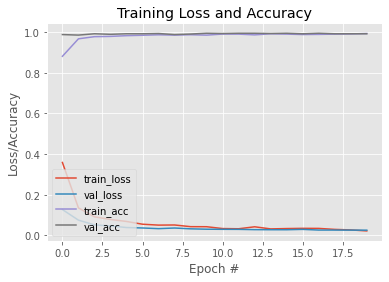

In [47]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot1.png")